
# Portfolio Optimization with [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/index.html)
--------
### Source code:
#### [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/index.html) documentation

#### [Example](https://riskfolio-lib.readthedocs.io/en/latest/examples.html) codes

----

## Efficient Portfolio
### In an efficient portfolio, investable assets are combined in a way that produces the best possible expected level of return for their level of risk—or the lowest risk for a target return. The line that connects all these efficient portfolios is known as the efficient frontier. The efficient frontier represents those portfolios that have the maximum rate of return for every given level of risk.

#### Source: [Investopedia](https://www.investopedia.com/terms/r/risk-parity.asp)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio.Portfolio as pf
import riskfolio.ConstraintsFunctions as cf
import riskfolio.PlotFunctions as plf
import riskfolio.Reports as rp
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Pandas_datareader override
yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

In [3]:
# Select date range to pull asset prices
start = '2016-01-01'
end = '2021-08-16'

In [4]:
# Select asset tickers
assets = ['BRK-B','ARKK','AGG','ETH-USD','QQQ']
assets.sort()

In [5]:
# Downloading data from yfinance
# Downloading data from yfinance
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  5 of 5 completed


In [6]:
# Calculate returns
Y = data[assets].pct_change().dropna()
display(Y.head())


,AGG,ARKK,BRK-B,ETH-USD,QQQ
Date,,,,,
2016-01-05,0.0463%,0.7996%,0.3824%,-0.4509%,-0.1735%
2016-01-06,0.3796%,-1.6857%,0.0610%,0.0720%,-0.9606%
2016-01-07,-0.0092%,-3.9334%,-1.4087%,-0.9313%,-3.1314%
2016-01-08,0.2213%,-1.1548%,-0.8882%,4.7541%,-0.8201%
2016-01-09,0.0000%,0.0000%,0.0000%,0.0045%,0.0000%


In [7]:
# Create constraints (you can create more detailed constraints - see example codes)
asset_classes = {'Assets': ['AGG', 'ARKK', 'BRK-B', 'ETH-USD','QQQ'],
                 'Class 1': ['Fixed Income', 'Equity', 'Equity', 'Crypto','Equity'],
                }
asset_classes = pd.DataFrame(asset_classes)
constraints = pd.read_excel('/Users/draganbogatic/Documents/Fin_Tech/portfolio_optimization/resources/constraints.xls',  index_col='Index')
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
Index,,,,,,,,,,
0,False,Classes,Class 1,Equity,>=,60.0000%,nan%,nan%,nan%,nan%
1,False,Classes,Class 1,Fixed Income,<=,30.0000%,nan%,nan%,nan%,nan%
2,False,Classes,Class 1,Crypto,<=,3.0000%,nan%,nan%,nan%,nan%
3,False,Assets,NaN,BRK-B,>=,30.0000%,nan%,nan%,nan%,nan%
4,False,Assets,NaN,BRK-B,<=,50.0000%,nan%,nan%,nan%,nan%
5,False,Assets,NaN,QQQ,<=,30.0000%,nan%,nan%,nan%,nan%
6,False,Assets,NaN,QQQ,>=,15.0000%,nan%,nan%,nan%,nan%
7,False,Assets,NaN,ARKK,<=,30.0000%,nan%,nan%,nan%,nan%


In [8]:
A, B = cf.assets_constraints(constraints, asset_classes)
A,B

(array([[ 0,  1,  1,  0,  1],
        [-1,  0,  0,  0,  0],
        [ 0,  0,  0, -1,  0],
        [ 0,  0,  1,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  1],
        [ 0, -1,  0,  0,  0]]),
 array([[ 0.6 ],
        [-0.3 ],
        [-0.03],
        [ 0.3 ],
        [-0.5 ],
        [-0.3 ],
        [ 0.15],
        [-0.3 ]]))

In [9]:
# Building the portfolio object
port = pf.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:
method_mu='hist' # Method to estimate expected returns based on historical data
method_cov='hist' # Method to estimate covariance matrix based on historical data
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

# Load constraints (you can optimize without constraints)
port.ainequality = A
port.binequality = B

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)


,AGG,ARKK,BRK-B,ETH-USD,QQQ
weights,30.0000%,20.0636%,30.0000%,3.0000%,16.9364%


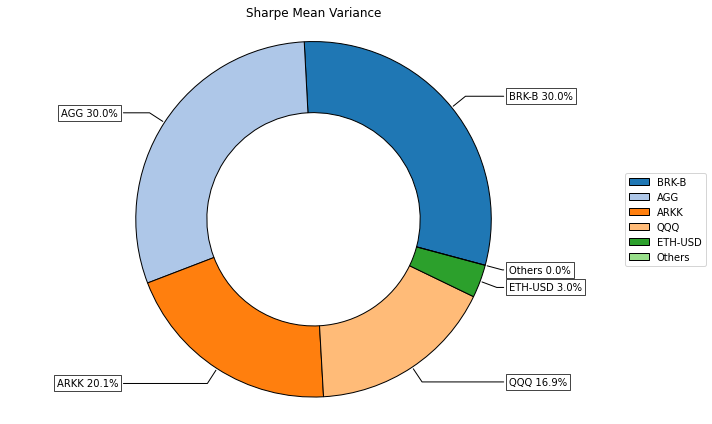

In [10]:
# Plotting the composition of the portfolio
ax = plf.plot_pie(w=w, title='Sharpe Mean Variance', others=0.02, nrow=25, cmap = "tab20", height=6, width=10, ax=None)

In [11]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AGG,ARKK,BRK-B,ETH-USD,QQQ
0,30.0000%,0.0000%,39.7787%,0.2213%,30.0000%
1,30.0000%,0.0000%,37.9134%,2.0866%,30.0000%
2,30.0000%,0.0000%,37.1328%,2.8672%,30.0000%
3,30.0000%,2.9591%,34.0409%,3.0000%,30.0000%
4,30.0000%,5.6383%,31.3617%,3.0000%,30.0000%


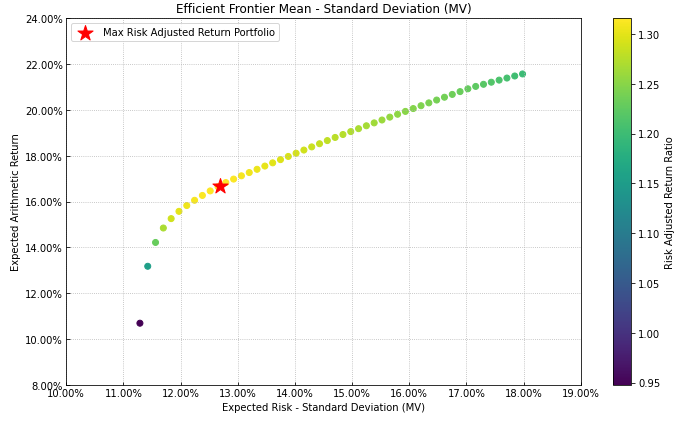

In [12]:
# Plotting the efficient frontier in Std. Dev. dimension
label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

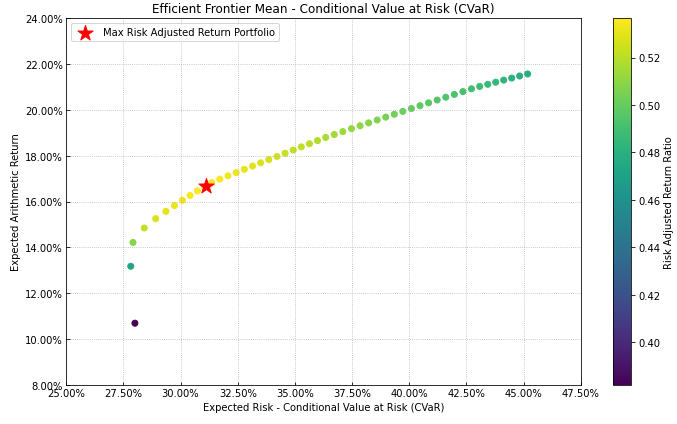

In [13]:
# Plotting the efficient frontier in CVaR dimension
ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm='CVaR',
                       rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

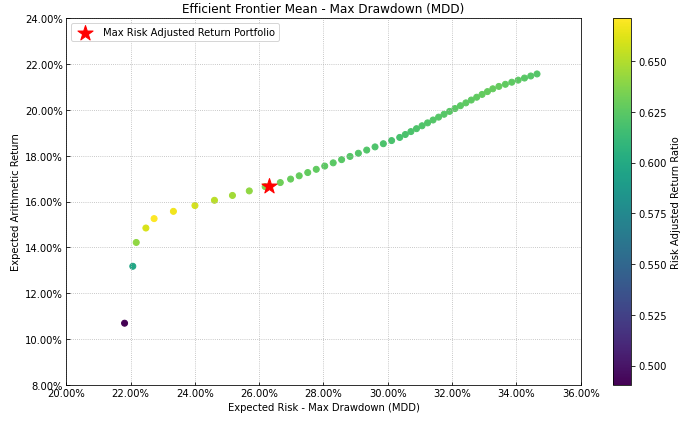

In [14]:
# Plotting the efficient frontier in Max Drawdown dimension
ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm='MDD',
                       rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

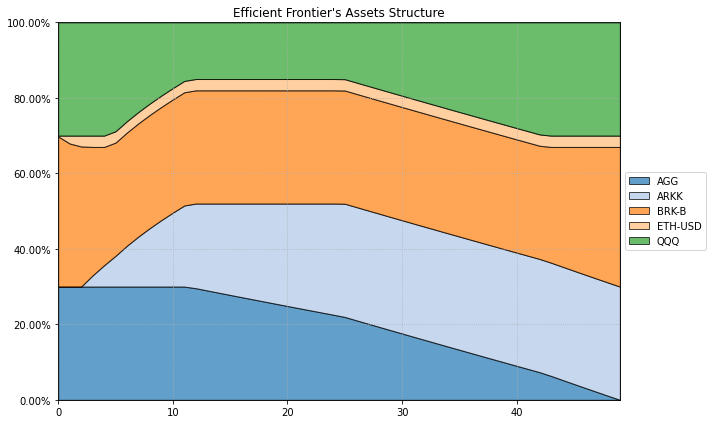

In [15]:
# Plotting efficient frontier composition

ax = plf.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [16]:
# See portfolio composition by asset
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)

,Class 1,weights
Assets,,
AGG,Fixed Income,30.0000%
ARKK,Equity,20.0636%
BRK-B,Equity,30.0000%
ETH-USD,Crypto,3.0000%
QQQ,Equity,16.9364%


In [17]:
# Risk Measures available:

# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
AGG,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,22.00%,11.57%,30.00%,30.00%,30.00%,30.00%,30.00%
ARKK,20.06%,11.85%,18.04%,12.73%,18.56%,22.00%,30.00%,30.00%,5.87%,17.62%,21.92%,21.22%,7.00%
BRK-B,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,31.13%,30.00%,30.08%,30.00%,30.00%
ETH-USD,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%
QQQ,16.94%,25.15%,18.96%,24.27%,18.44%,15.00%,15.00%,25.43%,30.00%,19.38%,15.00%,15.78%,30.00%


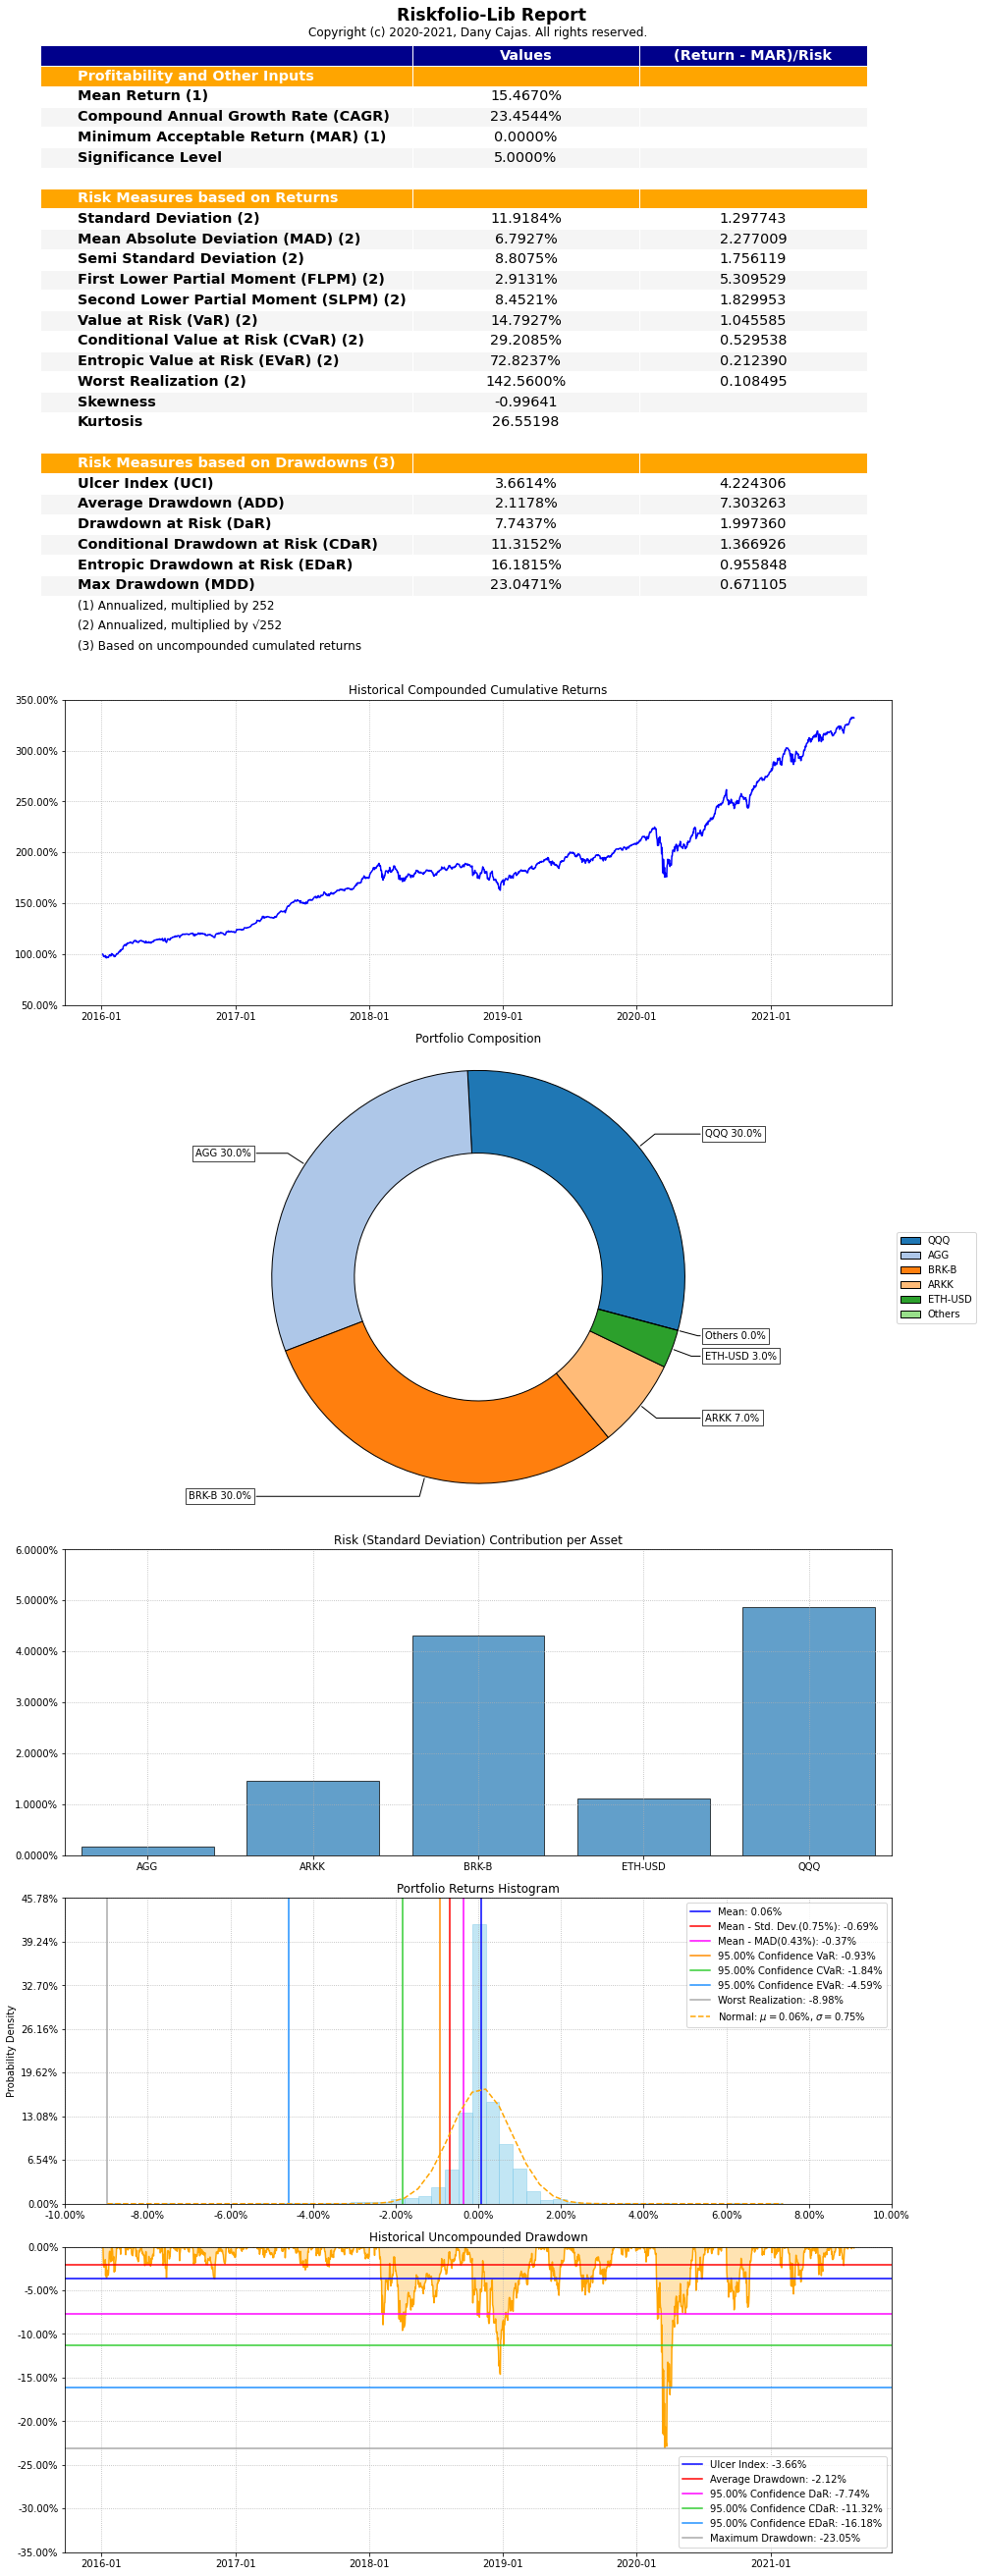

In [18]:
# Create portfolio report
ax = rp.jupyter_report(returns, w, rm='MV', rf=0, alpha=0.05, height=6, width=14,
                       others=0.02, nrow=25)